In [1]:
import os, operator
from typing import List, Annotated, Dict
from typing_extensions import TypedDict

from openai import OpenAI
from langchain_openai import ChatOpenAI
from langchain_core.messages import (
    SystemMessage,
    HumanMessage,
    AIMessage,
    BaseMessage,
)
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver
from pydantic import BaseModel, Field

from IPython.display import Image, display, Markdown

In [2]:
llm = ChatOpenAI(model="gpt-4o", temperature=0)

In [3]:
class State(TypedDict):
    idea: str
    messages: Annotated[List[BaseMessage], add_messages]
    advisor_reports: Annotated[Dict[str, str], operator.or_]
    final_report: str

In [4]:
base_system_msg = SystemMessage(
    content=(
        """
        You are a helpful tool
        Your job: decide whether you have enough information about the start-up idea.
        If not, ask ONE precise follow-up question.
        If yes, say: DONE
        """

    )
)

In [5]:
def decide_node(state: State):
    conversation = [base_system_msg] + state["messages"]
    ai_reply: AIMessage = llm(conversation)
    return {"messages": [ai_reply]} 

In [6]:
def route(state: State):
    last_ai_msg: AIMessage = state["messages"][-1]
    if last_ai_msg.content.strip().upper().startswith("DONE"):
        return "fanout"
    return "ask_user_node"



In [7]:
def ask_user_node(state: State):
    question = state["messages"][-1].content
    print(f"\nAssistant: {question}\n")
    human = input("You: ")
    new_messages = state["messages"] + [HumanMessage(content=human)]
    
    return {"messages": new_messages,
            "human_advisor_feedback": human,}

In [8]:
def market_analyst_advisor(state: State):
    prompt = f"""
    You are a helpfull senior MARKET ANALYST that gets an idea as an input. You need to Evaluate the market potential, competition, target demographics, and trends:
    Conduct market sizing and competitor research
    Identify target customers and segments
    Assess timing, trends, and macroeconomic influences
    Idea:
    {state['messages']}
    """
    report = llm.invoke([SystemMessage(content=prompt)])
    return {"advisor_reports": {"Market Analyst": report.content}}


In [9]:
def legal_advisor(state: State):
    prompt = f"""
    You are a helpfull Legal Advisor that gets an idea as an input. You need to:
    Identify IP, licensing, and trademark needs
    Spot compliance issues (e.g., GDPR, financial regulations)
    Evaluate contract and partnership considerations
    Idea:
    {state['messages']}
    """
    report = llm.invoke([SystemMessage(content=prompt)])
    return {"advisor_reports": {"Legal Advisor": report.content}}


In [10]:
def technical_advisor(state: State):
    prompt = f"""
    You are a helpfull  Technical/Product Feasibility Expert that gets an idea as an input. You need to:
    Estimate development complexity and time
    Recommend tech stacks or platforms
    Evaluate risk in terms of infrastructure, scalability, and cost
    Idea:
    {state['messages']}
    """
    report = llm.invoke([SystemMessage(content=prompt)])
    return {"advisor_reports": {"Technical Advisor": report.content}}

In [11]:
def strategist_advisor(state: State):
    prompt = f"""
    You are a helpfull Strategist Advisor Expert that gets an idea as an input. You need to:
    Define launch milestones
    Select distribution channels and positioning strategies
    Craft early traction tactics (e.g., community, influencers, PR)
    Idea:
    {state['messages']}
    """
    report = llm.invoke([SystemMessage(content=prompt)])
    return {"advisor_reports": {"Strategist Advisor": report.content}}

In [12]:
def collect_and_report(state: State):
    if len(state["advisor_reports"]) < 4:
        return {}
    report_prompt = f"""
    You are a senior consultant. Combine the four advisor notes below into one clear, 
    structured evaluation report for the founder.
    {state['advisor_reports']}
    """
    report = llm.invoke(report_prompt).content
    display(Markdown("### FINAL REPORT\n\n" + report))
    return {"final_report": report}

In [13]:
builder = StateGraph(State)

In [14]:
builder.add_node("decide_node", decide_node)
builder.add_node("ask_user_node", ask_user_node)
builder.add_node("fanout", lambda state: {}) # does nothing - just a hub
builder.add_node("market_analyst_advisor", market_analyst_advisor)
builder.add_node("legal_advisor", legal_advisor)
builder.add_node("technical_advisor", technical_advisor)
builder.add_node("strategist_advisor", strategist_advisor)
builder.add_node("collect_and_report", collect_and_report)

In [15]:
builder.set_entry_point("decide_node")
builder.add_edge("ask_user_node", "decide_node")
builder.add_conditional_edges(
    "decide_node", route, {"ask_user_node": "ask_user_node", "fanout": "fanout"}
)
builder.add_edge("fanout", "market_analyst_advisor")
builder.add_edge("fanout", "legal_advisor")
builder.add_edge("fanout", "technical_advisor")
builder.add_edge("fanout", "strategist_advisor")

builder.add_edge("market_analyst_advisor", "collect_and_report")
builder.add_edge("legal_advisor", "collect_and_report")
builder.add_edge("technical_advisor", "collect_and_report")
builder.add_edge("strategist_advisor", "collect_and_report")

builder.add_edge("collect_and_report", END)

graph = builder.compile()

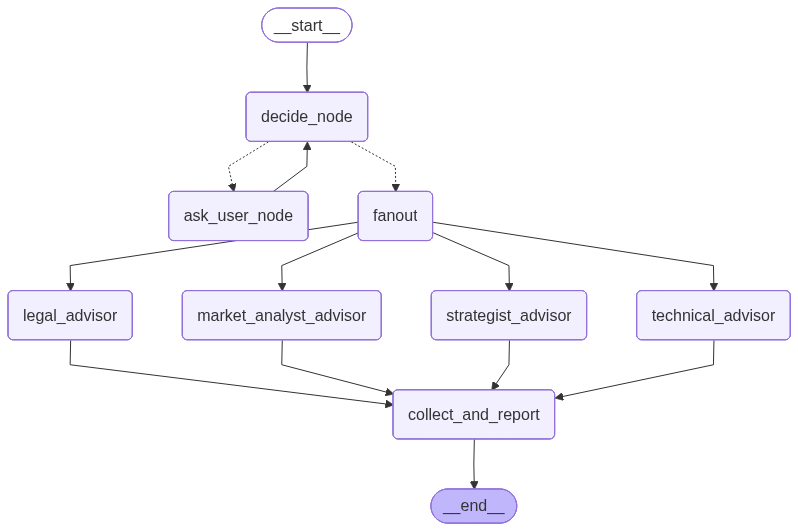

In [16]:
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [18]:
print("What is your business idea?")
idea = input("You: ")
    
init_state:  State = {
    "idea": idea,
    "messages": [HumanMessage(content=idea)],
    "advisor_reports": {},
    "final_report": "",
}
    
graph.invoke(init_state, config={"configurable": {"thread_id": "run-1"}});
        


What is your business idea?


You:  Bamboo tootbrush


C:\Users\365 Company\AppData\Local\Temp\ipykernel_36452\3340467931.py:3: LangChainDeprecationWarning: The method `BaseChatModel.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use :meth:`~invoke` instead.
  ai_reply: AIMessage = llm(conversation)



Assistant: What is the unique selling proposition or target market for your bamboo toothbrush?



You:  It has a great market in the western countries


### FINAL REPORT

**Evaluation Report for Bamboo Toothbrush Market Entry**

**Introduction:**
This report consolidates insights from legal, market, strategic, and technical advisors to provide a comprehensive evaluation of launching a bamboo toothbrush in Western markets. The analysis covers legal considerations, market potential, strategic planning, and technical feasibility, offering a roadmap for successful market entry.

**1. Legal and Regulatory Considerations:**
To ensure a smooth market entry, several legal and regulatory aspects must be addressed:

- **Intellectual Property (IP) and Licensing:**
  - Register trademarks for brand identity protection.
  - Consider design patents for unique product features.
  - Secure licenses for any third-party patented technologies.

- **Compliance:**
  - Adhere to product safety and environmental regulations, including sustainable sourcing and biodegradability claims.
  - Ensure GDPR compliance for data collection in the EU.

- **Contracts and Partnerships:**
  - Establish clear supplier and distributor agreements.
  - Negotiate favorable terms with retail partners to protect brand interests.

**2. Market Potential:**
The bamboo toothbrush market is poised for growth, driven by increasing environmental awareness:

- **Market Size and Growth:**
  - The market is part of the expanding eco-friendly products sector, with a projected CAGR of 7-10%.
  - Key competitors include The Humble Co., Brush with Bamboo, and WooBamboo.

- **Target Audience:**
  - Focus on environmentally conscious consumers aged 18-45, primarily in North America and Europe.
  - Appeal to consumers prioritizing health, wellness, and sustainability.

- **Trends and Influences:**
  - Leverage trends towards zero-waste and plastic-free products.
  - Benefit from supportive regulatory environments and resilient consumer interest in sustainability.

**3. Strategic Plan:**
A detailed strategy is essential for a successful launch:

- **Launch Milestones:**
  - Product development and testing (Months 1-3).
  - Branding and eco-friendly packaging (Months 2-4).
  - Pre-launch marketing and official launch (Months 4-6).
  - Post-launch evaluation (Month 7).

- **Distribution and Positioning:**
  - Utilize online platforms like Amazon and eco-friendly marketplaces.
  - Target health and wellness stores and major retail chains.
  - Position the product as a premium, eco-friendly alternative.

- **Early Traction Tactics:**
  - Build a community of eco-conscious consumers.
  - Partner with influencers and engage in PR and content marketing.
  - Support sustainability initiatives and recycling programs.

**4. Technical Feasibility:**
Developing a bamboo toothbrush involves several technical considerations:

- **Development Complexity:**
  - Medium complexity for design and prototyping; high for manufacturing setup.
  - Estimated timelines: 2-3 months for design, 6-12 months for manufacturing.

- **Recommended Platforms:**
  - Use Shopify or WooCommerce for e-commerce.
  - Implement supply chain management with TradeGecko or Odoo.
  - Manage customer relationships with HubSpot or Salesforce.

- **Risk Evaluation:**
  - Infrastructure and scalability risks can be mitigated through partnerships.
  - High initial costs require phased investment and potential grants.
  - Differentiate through unique design and strong branding to address market competition.

**Conclusion:**
Entering the bamboo toothbrush market in Western countries presents a promising opportunity, supported by growing demand for sustainable products. By addressing legal, market, strategic, and technical aspects, the company can effectively penetrate the market, attract eco-conscious consumers, and establish a strong brand presence. Careful planning and strategic partnerships will be key to overcoming challenges and achieving success.